# Installing Tensorflow 2.0

In [1]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 63kB/s 
     |████████████████████████████████| 501kB 39.7MB/s 
     |████████████████████████████████| 4.3MB 29.1MB/s 


# Importing dependencies

In [42]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import time

%matplotlib inline
print(tf.__version__)

2.0.0-rc1


# Configuration area

In [71]:
EPOCHS = 500
EPOCHS_TO_REPORT = 10.0
NOISE_DIM = 100
EXEMPLES_TO_GEN = 16
BUFFER_SIZE = 60000
BATCH_SIZE = 256
SEED = tf.random.normal([EXEMPLES_TO_GEN, NOISE_DIM])

checkpoints_dir = './training_chpk'
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Importing dataset

In [44]:

(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train / 127.5) -1 # Normalize images between -1 and 1

x_train_set = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Model architecture and utils


In [52]:
def create_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
  
  
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model  
  
  
def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
  
    return tot_loss
  

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)   
  
def generate_and_save_images(model, epoch, test_input, plot = False):

    # Training set to false so that every layer runs in inferenc mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap=plt.cm.binary)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    if plot:
        plt.show()  
    
    plt.close(fig)

# Trainning

In [53]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_img = generator(noise, training=True)

        true_output = discriminator(images, training=True)
        fake_output = discriminator(gen_img, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

In [65]:
def train(dataset, epochs, initial = 0):
    start = time.time()
    for epoch in range(initial, epochs):

        for img_batch in dataset:
            train_step(img_batch)

        if (epoch + 1) % EPOCHS_TO_REPORT == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            generate_and_save_images(generator, epoch+ 1, SEED)
            
            print ('Time for report {} is {} sec'.format((epoch + 1) // EPOCHS_TO_REPORT, time.time()-start))
            start = time.time()

In [74]:
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

generator = create_generator()
discriminator = create_discriminator()

checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer, dis_optimizer=dis_optimizer, generator=generator, discriminator=discriminator)

train(x_train_set, EPOCHS)

# Evaluating

Original images


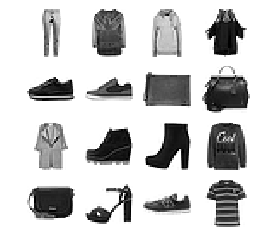

In [63]:
print("Original images")

i = 0
fig = plt.figure(figsize=(4,4))
for img_batch in x_train_set.take(EXEMPLES_TO_GEN):
  image = img_batch[0].numpy().reshape((28,28))
  plt.subplot(4, 4, i+1)
  plt.imshow(image,  cmap=plt.cm.binary)
  plt.axis('off')
  i+=1

plt.show()

Novel ones


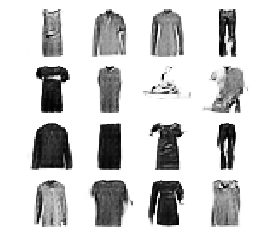

In [77]:
print("Novel ones")
SEED = tf.random.normal([16, 100])
generate_and_save_images(generator, EPOCHS, SEED, True)